<a href="https://colab.research.google.com/github/phas-ml/phas-ml.github.io/blob/master/notebooks/2021_02_10_normalising_flows_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An introduction to normalising flows**

**Michael J. Williams - 2021**

This notebook introduces the basics concepts behind normalising flows and explains how to implement a flow with affine coupling transforms using `nflows`.

# What is a normalising flow?

A normalising flow is a type of generative algorithm. They are somewhat similar to Generative Adverserial Networks (GANs) and Variational Autoencoders (VAEs but have some specific characteristics that set them apart from these methods.

Normalising flows are designed such that they map a complex distribution to a simple distribution, or vice versa. This simple distribution is known as the latent distribution. Those familiar with VAEs and GANs will recognise this concept.


---

![flows](https://lilianweng.github.io/lil-log/assets/images/normalizing-flow.png)

Image source: [Flow-based Deep Generative Models by Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)

---



## Mathematical definition

Before describing the structure of a normalising flow we'll focus on how they are defined mathematically. A normalising flow is an **invertible mapping** from one space to another. So an invertible function

$$
z = f(x) \quad | \quad x = f^{-1}(z)
$$

What makes a normalising flow different from a VAE or a GAN is the other mathematical requirement: the mapping must have a **tractable Jacobian determinant**

$$
|J| = \left| \frac{\partial f(x)}{\partial x} \right|.
$$

This property allows us define probability distribution using the normalising flow

$$
p_{x}(x) = p_{z}(f(x)) \left| \frac{\partial f(x)}{\partial x}\right|.
$$

Since we can choose the latent distribution $p_z$ to be a simple distribution, like a Guassian, this probability is easy to compute.

> **Note**: the terms mapping and transform are used interchangeably throughout this notebook.



## Constructing a normalising flow

So how do you construct an invertible function with a tractable Jacobian determinant that is also flexible enough to map from a complex distribution to a simple latent distribution?

There are two main types of flows:

* **Autoregressive flows**
* **Coupling transform based flows**

To understand the differences between these types of flows we're going to consider the transform from an N-dimensional vector $\mathbf{x}$ in the data space to an N-dimensional vector $\mathbf{z}$ in the latent space.



### Autoregressive flows

These normalising flows are constructed such that the transform applied to a given component in the vector $x_i$ is conditioned on the value of the previous component $x_{i-1}$. The overall transform is sequential, the tranforms are applied to each component of the vector in sequence:

$$
p_{x}(\mathbf{x}) = \prod_{i=1}^{N} p(x_{i}|\mathbf{x}_{1:i-1})
$$


This makes the transforms typically slower by design. We won't be focusing on this type of flow in this tutorial.



### Coupling transform based flows

Flows implemented with coupling transforms split the input vector in two parts:

* The first $n$ dimensions stay the same
* The second $n+1$ to $N$ dimensions are updated conditioned on the values of the first unchanged part of the vector

The exact method for updating the second part of the vector depends on the type of coupling transform being used. In this tutorial we'll consider one of the simple transforms: affine coupling transforms.

An affine coupling transform is defined in terms of a scale and translation operation, for an input vector $\mathbf{x}$ of length $N$ the output $\mathbf{y}$ is defined as

$$
\begin{split}
    \mathbf{y}_{1:n} & = \mathbf{x}_{1:n},\\
    \mathbf{y}_{n+1:N} & = \mathbf{x}_{n+1:N} \odot  \exp(s(\mathbf{x}_{1:n})) + t(\mathbf{x}_{1:n}),
\end{split}
$$

where $s(\mathbf{x}_{1:n})$ and $t(\mathbf{x}_{1:n})$ are a scaling vector and translation vector conditioned on $\mathbf{x}_{1:n}$ and $\odot$ is the element-wise product.

Since $\mathbf{y}_{1:n} = \mathbf{x}_{1:n}$ the Jacobian matrix of these transforms is lower triangular and the Jacobian determinant is simply the product of the diagonal entries.

#### Stacking coupling transforms

We can also combine multiple coupling transforms and alternate which part of the input vector is updated. This results in a far more expressive mapping.

**But how do you condition a scaling and translation vector on another vector?**

Use a neural network!

Let's think about this pictorially:

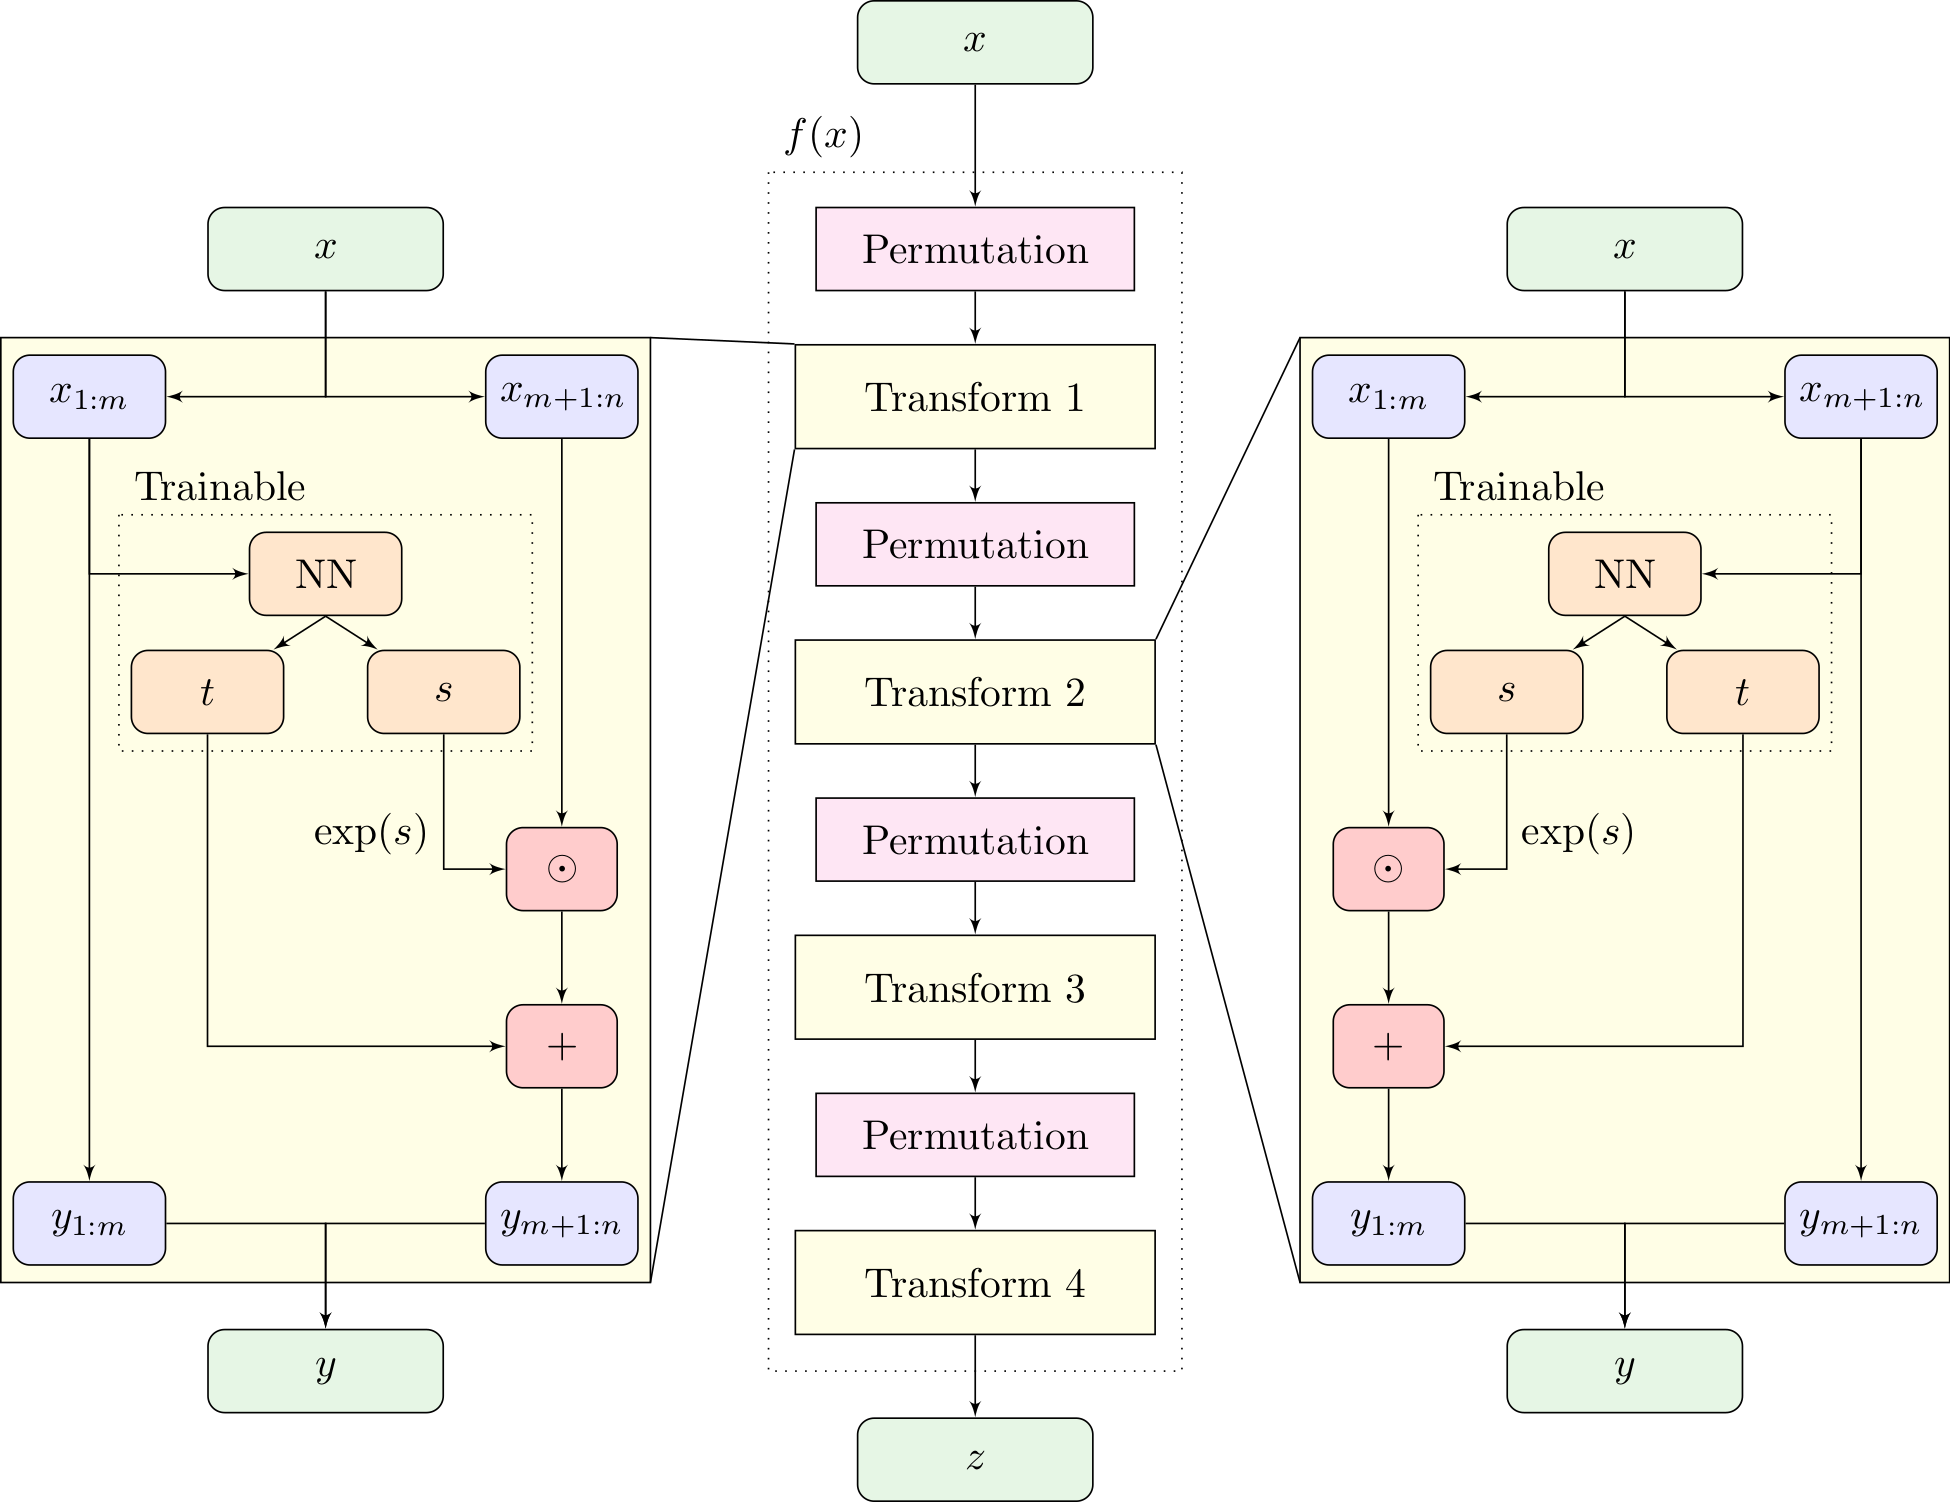


#### Compelete formulation

We can write the previous equation more explicity to include the parameters of the neural networks $\theta$ for a given coupling transform $i$ in a flow composed of multiple transforms:

$$
f_{i}(\mathbf{x}|\theta)
\begin{cases}
    & \mathbf{y}_{1:n} & = \mathbf{x}_{1:n},\\
                  & \mathbf{y}_{n+1:N} & = \mathbf{x}_{n+1:N} \odot  \exp(s(\mathbf{x}_{1:n}|\theta)) + t(\mathbf{x}_{1:n}|\theta),
\end{cases}
$$

So the probability can also be re-written:

$$
p_{x}(\mathbf{x}|\theta) = p_{z}(f(\mathbf{x}|\theta)) \left| \frac{\partial f(\mathbf{x}|\theta)}{\partial \mathbf{x}}\right|.
$$

## Loss function

As with any machine learning algorithm we need to define a loss function. This is actually relatively easy for a normalising flow.

A normalising flow applies a mapping $f: x \to z$ conditioned on its parameters $\theta$ which are typically the trainable parameters of a neural network. In this context the goal of training a normalising flow is to approximate a target distribution $p^{*}_{x}(x)$. The KL divergence between the target distribution and the distribution of the flow $p_{x}(x|\theta)$ can be written as:

$$
\begin{split}
    \mathcal{L}(\theta)  = & D_{\textrm{KL}}[p^{*}_{x}(x) ||p_{x}(x|\theta) ] \\
    = & - \mathbb{E}_{p^{*}_{x}(x)} [\ln p_{x}(x|\vec{\theta})] + \textrm{const.} \\
    = & - \mathbb{E}_{p^{*}_{x}(x)} \left[\ln p_{z}(f(x|\theta)) + \ln \left|\textrm{det} \frac{\partial f(x|\theta)}{\partial x^{T}} \right|\right] + \textrm{const.}.
\end{split}
$$

Then, assuming the set of K samples used for training is drawn from $p^{*}_{x}(x)$, the expectation value can be approximated as:

$$
    \mathcal{L}(\theta) \approx - \frac{1}{K} \sum_{k=1}^{K} \ln p_{z}(f(x|\vec{\theta})) + \ln \left|\textrm{det} \frac{\partial f(x|\vec{\theta})}{\partial x^{T}} \right|.
$$

This loss function is often known as the **negative log-likelihood** or NLL. In practice this is just the mean of the log-probabilties computed with the flow.

## Further reading

Here a some useful resources if you want to lean more about normalising flows:

### Blog posts / tutorials:

* [Normalizing Flows by Adam Kosiorek](http://akosiorek.github.io/ml/2018/04/03/norm_flows.html)
* [Flow-based Deep Generative Models by Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)

### Papers:

* [Normalizing Flows for Probabilistic Modeling and Inference](https://arxiv.org/abs/1912.02762)
* [Normalizing Flows: An Introduction and Review of Current Methods](https://arxiv.org/abs/1908.09257)

# Implementing a normalising flow

## Imports

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

sns.set_context('talk')
sns.set_style('ticks')

!pip install nflows

## Random seed

In [2]:
#@title Setting the random seed
seed =  1234#@param {type:"integer"}

np.random.seed(seed)
torch.random.manual_seed(seed)


# Implementing a normalising flow with coupling transforms

We're going to use [`nflows`](https://github.com/bayesiains/nflows) to implement a normalising flow with coupling transforms. In particular we're going to use Real Non Volume Preserving flows (or RealNVP) proposed in []. This is the formal name for the design of normalising flow we proposal earlier.

`nflows` includes the coupling transforms already, so we need to construct a model tha contain various coupling transforms. Each of these transforms will have a neural network that parameterises the scale and translation parameters. We're going to use a residual neural network, since this is also included in `nflows`.

In [3]:
import torch.nn.functional as F

from nflows.distributions import StandardNormal
from nflows import transforms
from nflows.nn.nets import ResidualNet

In [4]:
class RealNVP(torch.nn.Module):
    """
    Implementation of RealNVP using nflows.
   
    Parameters
    ----------
    n_dims : int
        Number of inputs the distribution to learn
    n_transforms : int
        Number of transforms to use
    n_layers_per_transform : int
        Number of layers in the neural network used for each transform
    n_neurons_per_layer : int
        Number of neurons per layer in the neural network
    """
    def __init__(self, 
                n_dims=None, 
                n_transforms=4,
                n_layers_per_transform=2,
                n_neurons_per_layer=16):
        super().__init__()

        # Define function for creating the neural network
        def create_net(in_features, out_features):
                return ResidualNet(
                    in_features,
                    out_features,
                    hidden_features=n_neurons_per_layer,
                    context_features=None,
                    num_blocks=n_layers_per_transform,
                    activation=F.elu,
                    dropout_probability=False,
                    use_batch_norm=False
                    )

        # Make an alternating mask. If the value is one, the parameter is updated
        # if it <0 then it is used as the input to the NN
        mask = torch.ones(n_dims)
        mask[::2] = -1

        transforms_list = []
        for i in range(n_transforms):
            transform = transforms.AffineCouplingTransform(
                mask=mask, transform_net_create_fn=create_net
            )
            mask *= -1
            transforms_list.append(transform)

        self.transform = transforms.CompositeTransform(transforms_list)
        self.distribution = StandardNormal([n_dims])

    def forward(self, x):
        """
        Apply the forward transformation and return samples in the latent
        space and log |J|
        """
        return self.transform.forward(x)

    def inverse(self, z):
        """
        Apply the inverse transformation and return samples in the
        data space and log |J| (not log probability)
        """
        return self.transform.inverse(z)

    def log_prob(self, x):
        """
        Computes the log probability of the inputs samples by applying the
        transform.
        """
        z, logabsdet = self.transform(x)
        log_prob = self.distribution.log_prob(z)
        return log_prob + logabsdet

    def sample(self, n):
        """
        Produces N samples in the data space by drawing from the base
        distribution and the applying the inverse transform.
        """
        z = self.distribution.sample(n)
        samples, _ = self.transform.inverse(z)
        return samples

We can now verify the properties of normalising flows that we described before:

* They are invertible
* They have a tractable Jacobian

Initial values: 
 [[ 1.1675476  -0.37601823]
 [-0.7070597   1.007707  ]
 [-0.54487485  0.01029185]
 [ 1.6330426  -1.4397552 ]]
Values out: 
 [[ 1.1675476  -0.37601826]
 [-0.7070597   1.007707  ]
 [-0.54487485  0.01029185]
 [ 1.6330426  -1.4397552 ]]

Plotting log probability


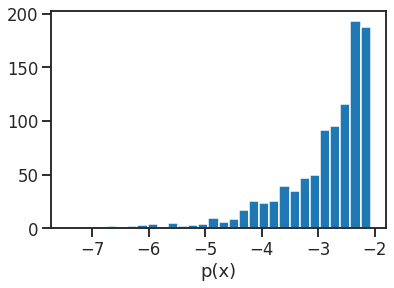

In [5]:
flow = RealNVP(2, 2, 2, 16)
# We don't need the gradients
with torch.no_grad():
    # Some placeholder data
    x = torch.randn(1000, 2)
    # Transform the data
    z, log_j = flow.forward(x)
    # Apply the inverse
    x_inv, log_j_inv = flow.inverse(z)

# If everything is implemented correctly, x and x_inv should be the same
# This function will raise an error if they're not equal
print('Initial values: \n', x[:4].numpy())
print('Values out: \n', x_inv[:4].numpy())
np.testing.assert_array_almost_equal(x, x_inv)
# The same applies to the Jacobian they should be equal (execpt for minus sign)
np.testing.assert_array_almost_equal(log_j, -log_j_inv)

# We can also compute the probability of the points
with torch.no_grad():
    log_prob = flow.log_prob(x)
print('\nPlotting log probability')
plt.hist(log_prob.numpy(), 'auto')
plt.xlabel('p(x)')
plt.show()

So we've implemented a normalising flow. It's missing a lot of the bells and whistles that make these transforms more expressive but it has the core functionality.

# Data

Now that we've defined a class for model, let's generate some data. We're going to use samples from a Rosenbrock distribution. This distrbution is 'banana-like.

The following cell will generate the number of samples specifed and define the variable `samples` and `log-likelihood`. The generation process is omitted here for simplicity.

In [6]:
#@title Generate data
#@markdown Generate sample from a Rosenbrock distribution. Returns `samples`

n = 20000 #@param {type:"integer"}

def _log_prob(x):
    """Rosenbrock log-likelihood"""
    return  -(np.sum(100. * (x[:,1:] - x[:,:-1] ** 2.) ** 2. + (1. - x[:,:-1]) ** 2., axis=1))

_log_prop = lambda x: np.zeros(x.shape[0])

N = 0
samples = np.empty([n, 2])
while N < n:
    x = np.random.uniform([-2, -1], [3, 8], (10000, 2))
    log_w = _log_prob(x) - _log_prop(x)
    log_w -= np.max(log_w)
    log_u = np.log(np.random.rand(log_w.size))
    acc = (log_w >= log_u)
    Ninc = min(acc.sum(), n-N)
    samples[N:(N+Ninc), :] =  x[acc, :][:Ninc]
    N += Ninc

log_likelihood = _log_prob(samples)

Let's the plot the data

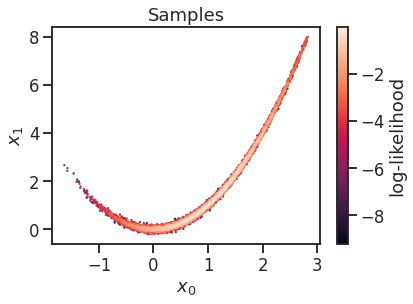

In [7]:
plt.title('Samples')
plt.scatter(*samples.T, c=log_likelihood, s=0.5)
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.colorbar(label='log-likelihood')
plt.show()

# Defining the model and training

## Model

Let's create an instance of the model. We have 2-dimensional input, so the `n_dims=2`.

The other variables we have choose some what randomly. The more complex the distribution, the more transforms we should use and the more complex the correlations between parameters, the more comples the neural network should be.

It's work tring a few different values and seeing how the results change.

In [8]:
# Create an instance of the model
flow = RealNVP(n_dims=2, 
               n_transforms=2, 
               n_layers_per_transform=2, 
               n_neurons_per_layer=2)
# Send to the GPU
flow.to('cuda')

RealNVP(
  (transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=1, out_features=2, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (linear_layers): ModuleList(
                (0): Linear(in_features=2, out_features=2, bias=True)
                (1): Linear(in_features=2, out_features=2, bias=True)
              )
              (dropout): Dropout(p=False, inplace=False)
            )
            (1): ResidualBlock(
              (linear_layers): ModuleList(
                (0): Linear(in_features=2, out_features=2, bias=True)
                (1): Linear(in_features=2, out_features=2, bias=True)
              )
              (dropout): Dropout(p=False, inplace=False)
            )
          )
          (final_layer): Linear(in_features=2, out_features=2, bias=True)
        )
      )
      (1): AffineCouplingTransform(

## Training setup

Now we difine the optimiser that we'll used to train the flow.

In [9]:
optimiser = torch.optim.Adam(flow.parameters(), lr=3e-3, weight_decay=1e-6)

Now some settings for training.

> **Patience** is the number of epochs without improvement that training will continue until it stops

In [10]:
# Configure training
n_epochs = 500
patience = 20
batch_size = 1000

We have the data, but it's not split into training and validation, so we can do that next. We'll use `train_test_split` from `sklearn` for simplicity.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:

x_train, x_val = train_test_split(samples, test_size=0.25)
train_tensor = torch.from_numpy(x_train.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

val_tensor = torch.from_numpy(x_val.astype(np.float32))

## Training

Now for the actual training, this should be familiar to anyone that has used pytorch before.

As explained previously, our loss function is just the log-probability. Since we're using batches of samples we'll use the mean of the batch to update the weights.

> **Remember**: when using pytorch you must set the model to `.train()` and `.eval()` in the training loop.

In [13]:
%%time
# Variables for checkpointing
best_epoch = 0
best_val_loss = np.inf
best_model = copy.deepcopy(flow.state_dict())

# Loss
loss_dict = dict(train=[], val=[])

for n in range(n_epochs):
    
    # Train
    train_loss = 0
    flow.train()
    for x_tensor in train_loader:
        optimiser.zero_grad()
        loss = -flow.log_prob(x_tensor[0].to('cuda')).mean()
        loss.backward()
        optimiser.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_loader)
    loss_dict['train'].append(train_loss)
    
    # Validate
    with torch.no_grad():
        flow.eval()
        val_loss = - flow.log_prob(val_tensor.to('cuda')).mean().cpu().numpy()
        
    loss_dict['val'].append(val_loss)

    # Save the bes model for use at the end
    if val_loss < best_val_loss:
        best_epoch = n
        best_val_loss = val_loss
        best_model = copy.deepcopy(flow.state_dict())
        
    # Print loss every n epochs
    if not n % 20:
        print(f'{n}: Train loss: {train_loss:1.4f}')
        print(f'{n}: Val loss: {val_loss:1.4f}')
        
    # Early stopping
    if n - best_epoch > patience:
        print('Reached patience')
        break

# Load the best model
print('Finished training')
print(f'Best epoch: {best_epoch}')
print('Loading best model')
flow.load_state_dict(best_model)
flow.eval()

0: Train loss: 3.4026
0: Val loss: 3.2672
20: Train loss: 2.2003
20: Val loss: 2.1966
40: Train loss: 2.0122
40: Val loss: 2.0112
60: Train loss: 1.9814
60: Val loss: 1.9796
80: Train loss: 1.9423
80: Val loss: 1.9388
100: Train loss: 1.8975
100: Val loss: 1.8961
120: Train loss: 1.8910
120: Val loss: 1.8907
140: Train loss: 1.8889
140: Val loss: 1.8886
160: Train loss: 1.8880
160: Val loss: 1.8878
180: Train loss: 1.8873
180: Val loss: 1.8873
200: Train loss: 1.8871
200: Val loss: 1.8868
220: Train loss: 1.8867
220: Val loss: 1.8868
240: Train loss: 1.8864
240: Val loss: 1.8863
260: Train loss: 1.8863
260: Val loss: 1.8865
280: Train loss: 1.8862
280: Val loss: 1.8861
300: Train loss: 1.8864
300: Val loss: 1.8865
320: Train loss: 1.8861
320: Val loss: 1.8860
340: Train loss: 1.8869
340: Val loss: 1.8881
360: Train loss: 1.8860
360: Val loss: 1.8859
Reached patience
Finished training
Best epoch: 349
Loading best model
CPU times: user 1min 3s, sys: 529 ms, total: 1min 3s
Wall time: 1min

We can now look at the loss functions

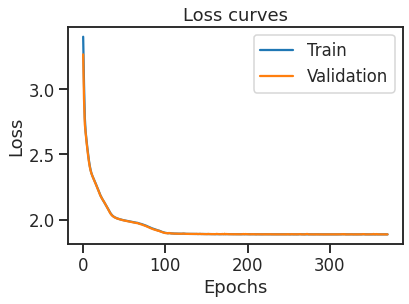

In [14]:
plt.plot(loss_dict['train'], label='Train')
plt.plot(loss_dict['val'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')
plt.show()

# Using the trained model

Now that we have trained the model we use it for generating new samples or computing the probablity of a given sample.

Before that let's examine the flow now that it's trained so we better understand what's happening.

## Examining the latent space

We've trained the flow to map the Rosenbrock distribution to a Gaussian. We can now test that by transforming the validation data using `flow.forward`. The sample should look Gaussian.

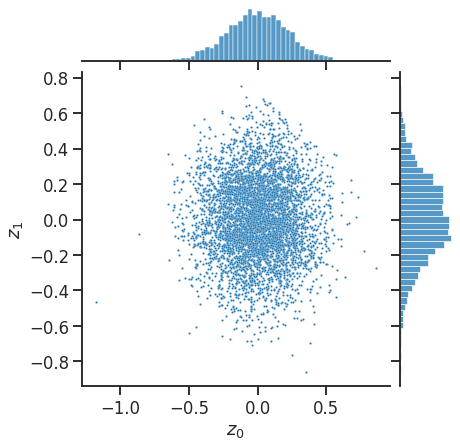

In [15]:
with torch.no_grad():
    z, _ = flow.forward(val_tensor.to('cuda'))
    z = z.cpu().numpy()

fig = sns.jointplot(x=z[:,0], y=z[:,1], joint_kws={'s': 5.0})
fig.ax_joint.set_xlabel(r'$z_0$')
fig.ax_joint.set_ylabel(r'$z_1$')
plt.show()

## Examining the transforms

### Function for plotting transforms

In [16]:
def plot_transforms(x, flow, device='cuda'):
    """
    Plot the transformation of the samples after each transform in the flow
    """
    outputs = []
    inputs = torch.from_numpy(x.astype('float32')).to(device)

    n = 0
    for module in flow._modules['transform']._modules['_transforms']:
        inputs, _ = module(inputs)
        outputs.append(inputs.detach().cpu().numpy())
        n += 1
    print(f'Flow has {n} transforms')

    final = outputs[-1]
    pospos = np.where(np.all(final >= 0, axis=1))
    negneg = np.where(np.all(final < 0, axis=1))
    posneg = np.where((final[:, 0] >= 0) & (final[:, 1] < 0))
    negpos = np.where((final[:, 0] < 0) & (final[:, 1] >= 0))

    points = [pospos, negneg, posneg, negpos]
    colours = plt.cm.Set2(np.linspace(0, 1, 8))
    print('Plotting the transforms')
    print('Plotting inputs')
    fig, ax = plt.subplots(1, n + 1,  figsize=(n * 5, 4))
    ax = ax.ravel()
    for j, c in zip(points, colours):
        ax[0].scatter(x[j, 0], x[j, 1], color=c, s=1.0)
    ax[0].set_title('Inputs')

    for i, o in enumerate(outputs, start=1):
        print(f'Plotting outputs from transform {i}')
        for j, c in zip(points, colours):
            ax[i].scatter(o[j, 0], o[j, 1], color=c, s=1.0)
        ax[i].set_title(f'Transform {i}')
    plt.tight_layout()
    return fig

### Plot the transforms

If we plot the ouput after each transform we can see how only one dimension is updated at a time.

Flow has 2 transforms
Plotting the transforms
Plotting inputs
Plotting outputs from transform 1
Plotting outputs from transform 2


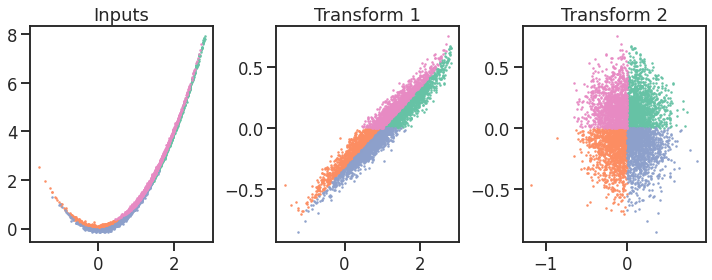

In [17]:
fig = plot_transforms(val_tensor.numpy(), flow)
plt.show()

## Log-probability

If we were using data where the likelihood a given sample was unknown we could use the trained flow to compute $p_x(x)$ for a new sample.

If we consider a grid of points we can compute the log-probablity at each point and plot the contours.

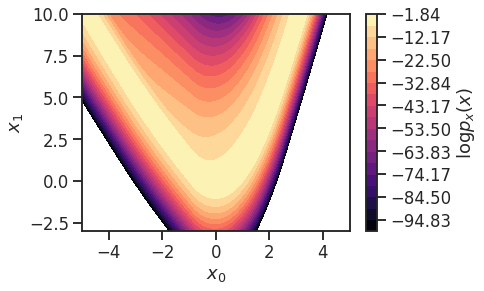

In [18]:
# Make the grid and flatten it for the flow
grid_x, grid_y = torch.meshgrid(torch.linspace(-5, 5, 100), torch.linspace(-3, 10, 100))
grid_tensor = torch.cat([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)], axis=1)
with torch.no_grad():
    log_p_grid = flow.log_prob(grid_tensor.to('cuda')).cpu().numpy()

# Plot the results
# There are some very negative vaues so we only show contours for logL > -100
levels = np.linspace(-100, log_p_grid.max(), 20)
plt.contourf(grid_x, grid_y, log_p_grid.reshape(grid_x.shape[0], -1), levels=levels, cmap='magma')
plt.colorbar(label=r'$\log p_{x}(x)$')
plt.xlabel('$x_0$')
plt.ylabel(r'$x_1$')
plt.show()

We can see the characteristic 'banana' shape here.

## Drawing new samples

Finally we can draw new samples from the normalising flow by sampling from the latent distribution and applying the inverse transformation.

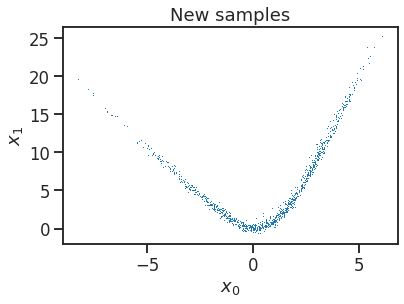

In [19]:
n = 1000
with torch.no_grad():
    x_out = flow.sample(n).cpu().numpy()
plt.plot(*x_out.T, ',')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title('New samples')
plt.show()

# Generating MNIST

This example uses one digit from MNIST a trains a normalising flow to generate that digit. This requires an improved version of the flow which incorporates
a few more features to make it more expressive and quicker to train.

In [20]:
#@title Choose a digit
digit = 4 #@param ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] {type:"raw", allow-input: true}

## Improved flow class

In [21]:
from torchvision import datasets, transforms as T

In [22]:
class ImprovedRealNVP(torch.nn.Module):
    def __init__(self, 
                n_dims=None, 
                n_transforms=4,
                n_layers_per_transform=2,
                n_neurons_per_layer=16):
        super().__init__()

        # Define function for creating the neural network
        def create_net(in_features, out_features):
                return ResidualNet(
                    in_features,
                    out_features,
                    hidden_features=n_neurons_per_layer,
                    context_features=None,
                    num_blocks=n_layers_per_transform,
                    activation=F.elu,
                    dropout_probability=False,
                    use_batch_norm=True
                    )
        
        def create_linear_transform():
            return transforms.CompositeTransform([
                transforms.RandomPermutation(features=n_dims),
                transforms.LULinear(n_dims, identity_init=True,
                                    using_cache=False)
            ])

        # Make an alternating mask. If the value is one, the parameter is updated
        # if it <0 then it is used as the input to the NN
        mask = torch.ones(n_dims)
        mask[::2] = -1

        transforms_list = []
        for i in range(n_transforms):
            transforms_list.append(create_linear_transform())
            transform = transforms.AffineCouplingTransform(
                mask=mask, transform_net_create_fn=create_net
            )
            transforms_list.append(transforms.BatchNorm(features=n_dims))
            mask *= -1
            transforms_list.append(transform)

        self.transform = transforms.CompositeTransform(transforms_list)
        self.distribution = StandardNormal([n_dims])

    def forward(self, x):
        """
        Apply the forward transformation and return samples in the latent
        space and log |J|
        """
        return self.transform.forward(x)

    def inverse(self, z):
        """
        Apply the inverse transformation and return samples in the
        data space and log |J| (not log probability)
        """
        return self.transform.inverse(z)

    def log_prob(self, x):
        """
        Computes the log probability of the inputs samples by applying the
        transform.
        """
        z, logabsdet = self.transform(x)
        log_prob = self.distribution.log_prob(z)
        return log_prob + logabsdet

    def sample(self, n):
        """
        Produces N samples in the data space by drawing from the base
        distribution and the applying the inverse transform.
        """
        z = self.distribution.sample(n)
        samples, _ = self.transform.inverse(z)
        return samples

## Set up the model and data

In [23]:
flow = ImprovedRealNVP(784, 4, 2, 16)
flow.to('cuda')
optimiser = torch.optim.Adam(flow.parameters(), lr=5e-4, weight_decay=1e-6)
# Configure training
n_epochs = 50
patience = 10
batch_size = 1000

Use the MNIST dataset which is include in pytorch.

In [24]:
transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,)),
        T.Lambda(lambda x: torch.flatten(x))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
idx = dataset1.targets==digit
dataset1.data = dataset1.data[idx]

idx = dataset2.targets==digit
dataset2.data = dataset2.data[idx]

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

## Train the flow

0: Train loss: -264.0711
0: Val loss: 55139.9883
Example generation:


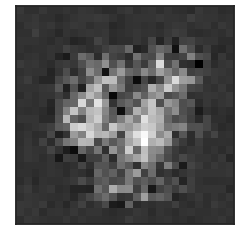

5: Train loss: -566.3424
5: Val loss: -167.2447
Example generation:


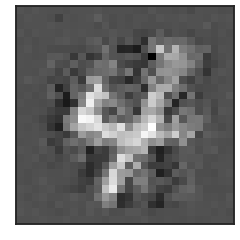

10: Train loss: -825.2810
10: Val loss: -232.8076
Example generation:


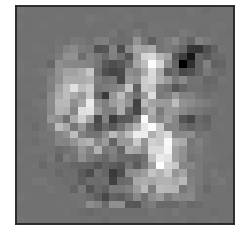

15: Train loss: -962.0069
15: Val loss: 178.4763
Example generation:


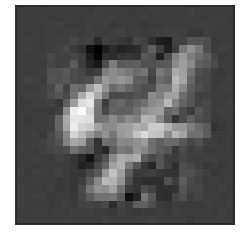

Reached patience
Finished training
Best epoch: 8
Loading best model
CPU times: user 29.3 s, sys: 1.09 s, total: 30.4 s
Wall time: 30.4 s


In [25]:
%%time
# Variables for checkpointing
best_epoch = 0
best_val_loss = np.inf
best_model = copy.deepcopy(flow.state_dict())

# Loss
loss_dict = dict(train=[], val=[])

for n in range(n_epochs):
    
    # Train
    train_loss = 0
    flow.train()
    for x_tensor in train_loader:
        optimiser.zero_grad()
        loss = -flow.log_prob(x_tensor[0].to('cuda')).mean()
        loss.backward()
        optimiser.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_loader)
    loss_dict['train'].append(train_loss)
    
    # Validate
    val_loss = 0
    with torch.no_grad():
        flow.eval()
        for x_tensor in test_loader:
            val_loss += -flow.log_prob(x_tensor[0].to('cuda')).mean().cpu().numpy()
    train_loss /= len(test_loader)

    loss_dict['val'].append(val_loss)

    # Save the bes model for use at the end
    if val_loss < best_val_loss:
        best_epoch = n
        best_val_loss = val_loss
        best_model = copy.deepcopy(flow.state_dict())
        
    # Print loss every n epochs
    if not n % 5:
        print(f'{n}: Train loss: {train_loss:1.4f}')
        print(f'{n}: Val loss: {val_loss:1.4f}')
        print('Example generation:')
        with torch.no_grad():
            x_out = flow.sample(1).cpu().numpy()
        plt.imshow(x_out.reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
    # Early stopping
    if n - best_epoch > patience:
        print('Reached patience')
        break

# Load the best model
print('Finished training')
print(f'Best epoch: {best_epoch}')
print('Loading best model')
flow.load_state_dict(best_model)
flow.eval()

## Loss function

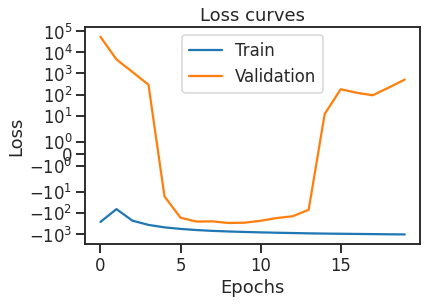

In [26]:
plt.plot(loss_dict['train'], label='Train')
plt.plot(loss_dict['val'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')
plt.yscale('symlog')
plt.show()

## Generations

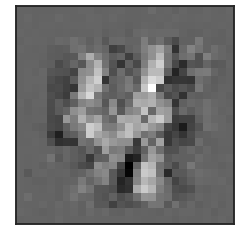

In [27]:
with torch.no_grad():
    x_out = flow.sample(1).cpu().numpy()
plt.imshow(x_out.reshape(28, 28), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()